## A News Reader Coding Implementation

### Overview
- In this project, I build a news reader that involves extracting news titles, preprocessing the text, performing topic modeling, classifying sentiment, and visualizing the results.
- I used python and several libraries, including requests, BeautifulSoup, sklearn, nltk, pandas, numpy, and wordcloud.


My Screen-cast: https://cloud.bht-berlin.de/index.php/s/76efFBADs4kEqnk

In [1]:
import requests
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define URL
url = "https://www.bbc.com/news/world"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the title elements
titles = soup.find_all('h3')

# Extract the text from the title elements
title_texts = [title.get_text() for title in titles]
title_texts = list(set(title_texts))

# This is Data Preprocessing Function
def preprocess_text(text):
    # Remove special characters and extra whitespace
    processed_text = re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    processed_text = ' '.join(word for word in processed_text.split() if word not in stop_words)
    return processed_text

preprocessed_titles = [preprocess_text(title) for title in title_texts[:-3]]  # Exclude the last three irrelivent titles

# This is Topic Modeling Function
def perform_topic_modeling(texts, num_topics=5):
    vectorizer = CountVectorizer()
    text_matrix = vectorizer.fit_transform(texts)
    #Applied LatentDirichletAllocation, a topic modeling algorithm, to the text matrix.
    lda_model = LatentDirichletAllocation(n_components=num_topics)
    lda_output = lda_model.fit_transform(text_matrix)
    #Retrieves the feature names from the vectorizer and generates a list of topic words for each topic.
    words = vectorizer.get_feature_names_out()
    topic_word_list = []
    for topic in lda_model.components_:
        topic_words = [words[i] for i in topic.argsort()[-20:]]
        topic_word_list.append(topic_words)
    return vectorizer, lda_model, topic_word_list, lda_output

num_topics = 3
vectorizer, lda_model, topic_word_list, lda_output = perform_topic_modeling(preprocessed_titles, num_topics)

#Sentiment Classification
def classify_sentiment(text):
    #SentimentIntensityAnalyzer from nltk to analyze the sentiment of the text.
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    #If the compound score is equal to or greater than 0, the sentiment is classified as positive; otherwise, it is classified as negative.
    sentiment_label = 'Positive' if sentiment_scores['compound'] >= 0 else 'Negative'
    return sentiment_label

#Created empty lists to store the results
title_list = []
preprocessed_text_list = []
topic_list = []
sentiment_list = []
topic_percent_list = []

#Process the data and append the results to the lists
for i, title in enumerate(title_texts[:-3]):  # Exclude the last three titles
    if title not in ["Get in touch", "Mobile app", "News daily newsletter"]:
        title_list.append(title)
        preprocessed_text = preprocess_text(title)
        preprocessed_text_list.append(preprocessed_text)
        #Use topic model to assign a topic to the title and calculates the highest topic score.
        topic = lda_model.transform(vectorizer.transform([preprocessed_text]))
        highest_topic = np.argmax(topic) + 1
        highest_score = np.max(topic)
        topic_str = f"{highest_score:.3f}% Topic:{highest_topic}"
        #Formats the topic information into a string and appends it to the topic_list
        topic_list.append(topic_str)
        sentiment = classify_sentiment(title)
        sentiment_list.append(sentiment)
        #Appends the topic percentages to the topic_percent_list
        topic_percent_list.append([round(p, 3) for p in topic[0]])

# Created a dictionary with the data
data = {
    'Preprocessed Title': preprocessed_text_list,
    'Sentiment': sentiment_list,
    'Highest Topic Score': topic_list,
    'All Topic Percentages': topic_percent_list
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
print(df.to_string(index=False))

                                  Preprocessed Title Sentiment Highest Topic Score All Topic Percentages
         veteran antiapartheid exminister pahad dies  Positive      0.888% Topic:2 [0.056, 0.888, 0.056]
        teenager died trying save friend us shooting  Positive      0.916% Topic:3 [0.042, 0.042, 0.916]
               sweden jails kurd financing terrorism  Negative      0.888% Topic:2 [0.056, 0.888, 0.056]
         winemakers learn firefighting stay business  Positive      0.888% Topic:3 [0.056, 0.056, 0.888]
                canadian farmer fined thumbsup emoji  Positive      0.888% Topic:1 [0.888, 0.056, 0.056]
         female workers made strip used sanitary pad  Positive      0.916% Topic:1 [0.916, 0.042, 0.042]
                      bacteria living inside tumours  Positive      0.861% Topic:3 [0.072, 0.067, 0.861]
                   tourist carved colosseum know old  Positive      0.888% Topic:3 [0.056, 0.056, 0.888]
                 sculpture reflects conflict ukraine  N

#### Here I did some visualization using wordcloud, matplotlib and seaborn.

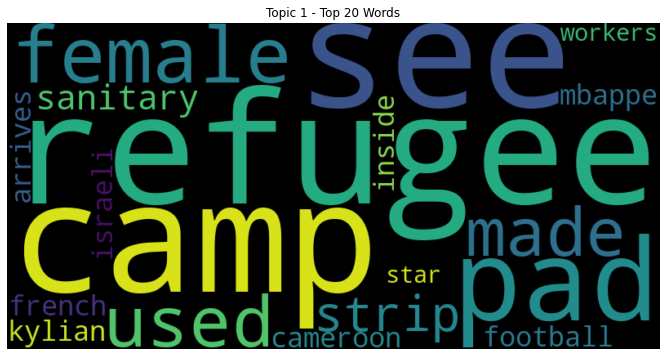

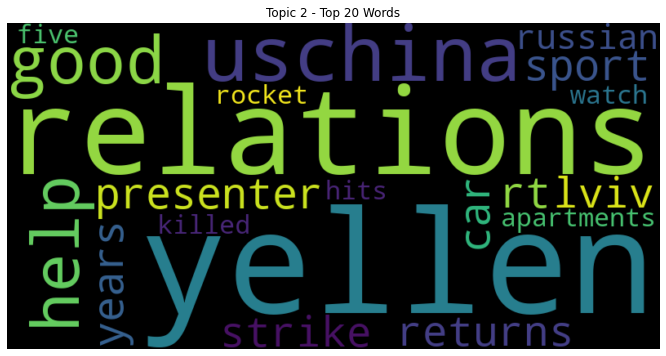

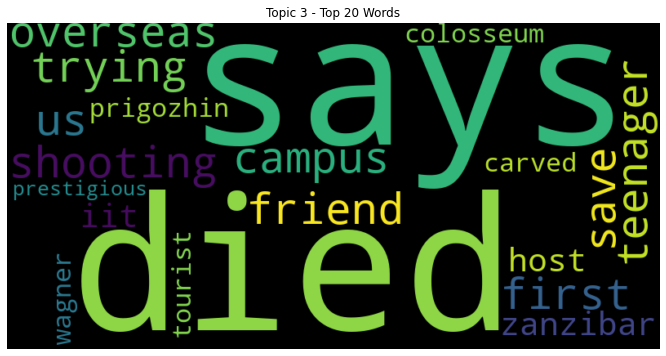

In [2]:
# Generate and display the word clouds for each topic
for i, topic_words in enumerate(topic_word_list):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(topic_words))
    plt.figure(figsize=(20, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i+1} - Top 20 Words')
    plt.axis('off')
    plt.show()

####  Distribution of Sentiment and Topic

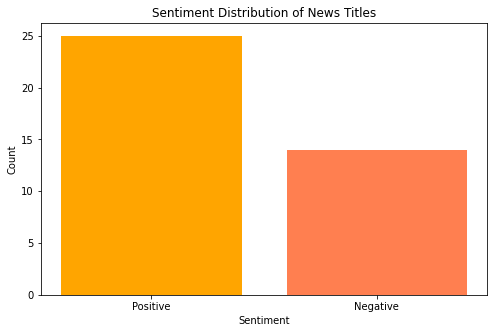

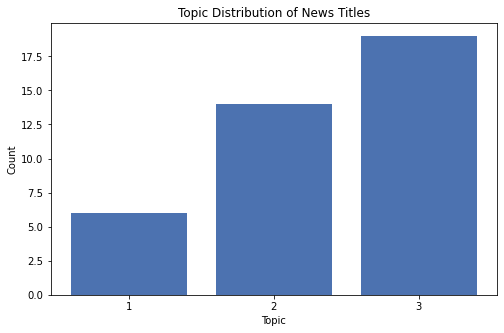

In [3]:
import seaborn as sns

# Bar Plot for Sentiment Distribution
def plot_sentiment_distribution(sentiment_list):
    sentiment_counts = pd.Series(sentiment_list).value_counts()
    plt.figure(figsize=(8, 5))
    plt.bar(sentiment_counts.index, sentiment_counts.values, color=['orange', 'coral'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Distribution of News Titles')
    plt.show()

# Bar Plot for Topic Distribution with Color Palette
def plot_topic_distribution(df, num_topics):
    topic_counts = df['Highest Topic Score'].apply(lambda x: int(x.split(':')[1])).value_counts().sort_index()
    sns.set_palette("deep")  # Set the color palette
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, num_topics + 1), topic_counts.values)
    plt.xticks(range(1, num_topics + 1))
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.title('Topic Distribution of News Titles')
    plt.show()

# Visualization
plot_sentiment_distribution(df['Sentiment'])
plot_topic_distribution(df, num_topics)
